In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle 
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.inspection import PartialDependenceDisplay

sys.path.append('../')

from src.training.bankmarketing import *

## Train on full data

In [2]:
bmfull = BankMarketingModel()
bmfull.train_bank_model()

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


In [8]:
bmfull.print_metrics()

ROC AUC train :  0.7664629014914208 
 ROC AUC val :  0.721882153876779 
 ROC AUC test :  0.7489543198956569 

Precision test :  0.43548387096774194
Recall test :  0.5934065934065934


## Train without campaign features

In [4]:
bmred = BankMarketingModel(full=False)
bmred.train_bank_model()

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


In [9]:
bmred.print_metrics()

ROC AUC train :  0.7545964046940016 
 ROC AUC val :  0.6638424405295112 
 ROC AUC test :  0.7096232553258475 

Precision test :  0.5753424657534246
Recall test :  0.46153846153846156


## Compare results

In [12]:
roc_auc_diff = np.round(roc_auc_score(bmfull.y_test, bmfull.grid_pipe_lgbm.predict(bmfull.X_test)) 
                - roc_auc_score(bmred.y_test, bmred.grid_pipe_lgbm.predict(bmred.X_test)), 3)

print(f"""Adding campaign related features to the model results in {roc_auc_diff} increase in ROC AUC score""")

Adding campaign related features to the model results in 0.039 increase in ROC AUC score


## Feature importance

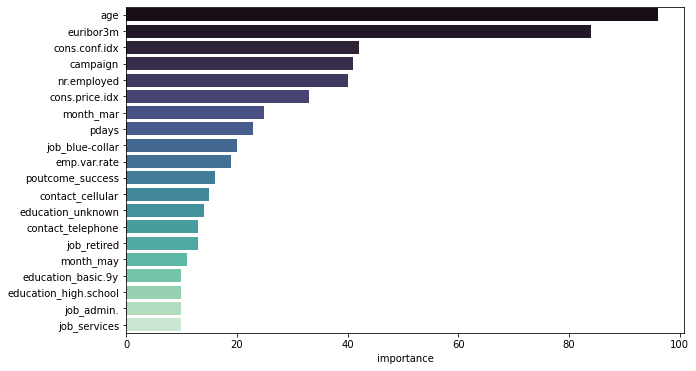

In [15]:
bmfull.get_fimp()

Campaign feature is in the top. 

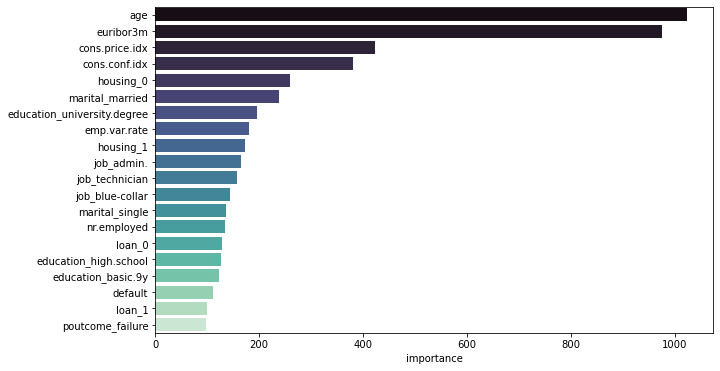

In [17]:
bmred.get_fimp()